In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
lob_data= pd.read_csv("C:\\Users\\yhb\\dsmp-2024-group23\\Ryan\\datasets\\resampled_lob_minALL.csv")
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])

lob_data['price']=(lob_data['Max Bid Price']*lob_data['Max Bid Quantity']+lob_data['Min Ask Price']*lob_data['Min Ask Quantity'])/(lob_data['Max Bid Quantity']+lob_data['Min Ask Quantity'])
lob_data

,Datetime,Min Ask Price,Max Bid Price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,price
0,2025-01-02 00:00:00,271.841538,260.186154,22881.0,16799.0,3,5,264.556923
1,2025-01-02 00:01:00,262.803138,258.206847,24821.0,12978.0,2,3,260.045364
2,2025-01-02 00:02:00,267.596615,262.929478,33966.0,11786.0,2,3,264.796333
3,2025-01-02 00:03:00,267.066274,262.751105,30396.0,15613.0,3,2,265.340206
4,2025-01-02 00:04:00,268.358289,263.077540,28408.0,16458.0,3,4,265.340718
...,...,...,...,...,...,...,...,...
62853,2025-07-01 08:13:00,151.230132,96.942053,18271.0,10399.0,3,4,120.208373
62854,2025-07-01 08:14:00,200.771852,107.148148,16849.0,10211.0,2,3,144.597630
62855,2025-07-01 08:15:00,174.894172,107.539877,29053.0,9511.0,2,4,129.991309
62856,2025-07-01 08:16:00,174.897866,108.716463,33890.0,9471.0,2,6,125.261814


## 1. ARIMA模型预测

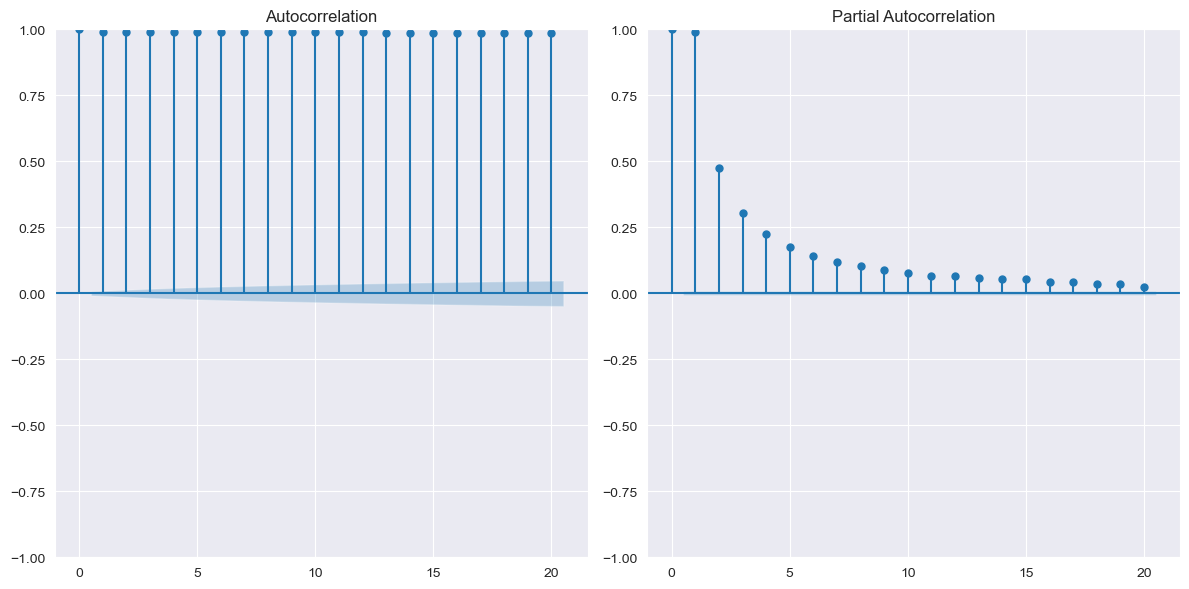

(-0.9932663450060103,
 0.7557123171688638,
 47,
 62810,
 {'1%': -3.4304541166577067,
  '5%': -2.8615860176312657,
  '10%': -2.5667944936271643},
 444063.07376444875)

In [17]:
# 对Min Ask Price进行ADF平稳性检测
adf_result = adfuller(lob_data['price'])

# 获取ACF和PACF值
lag_acf = acf(lob_data['price'], nlags=20)
lag_pacf = pacf(lob_data['price'], nlags=20, method='ols')

# 绘制ACF和PACF图
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(lob_data['price'], ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(lob_data['price'], ax=plt.gca(), lags=20)
plt.tight_layout()
plt.show()

adf_result

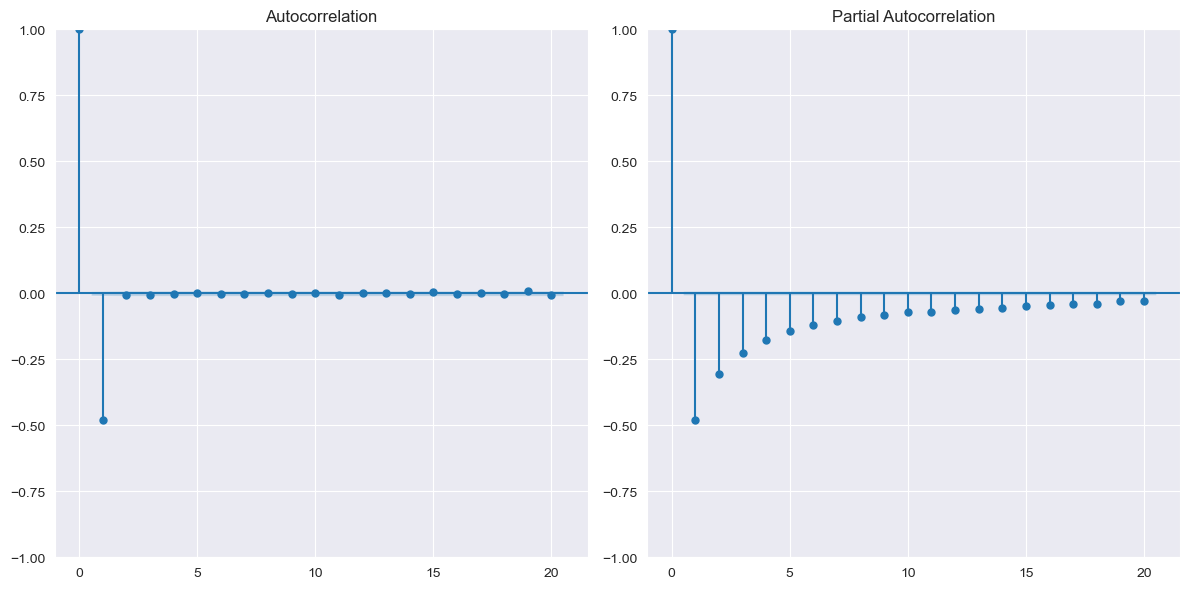

(-50.132170619836785,
 0.0,
 46,
 62810,
 {'1%': -3.4304541166577067,
  '5%': -2.8615860176312657,
  '10%': -2.5667944936271643},
 444053.6898218971)

In [19]:
# 对Min Ask Price进行一阶差分
lob_data['Price Diff'] = lob_data['price'].diff()

# 再次对一阶差分后的数据进行ADF平稳性检测
adf_result_diff = adfuller(lob_data['Price Diff'].dropna())

# 再次绘制ACF和PACF图，这次是对一阶差分后的数据
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(lob_data['Price Diff'].dropna(), ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(lob_data['Price Diff'].dropna(), ax=plt.gca(), lags=20)
plt.tight_layout()
plt.show()

adf_result_diff




**自相关和偏自相关图分析**:
- 自相关图（ACF）显示在第一个滞后处有一个显著的跳跃，之后迅速接近零并保持在置信区间内。这通常表示数据经过差分后已经变得平稳。
- 偏自相关图（PACF）显示在第一个滞后之后的所有滞后点都接近零并且均在置信区间内，这也是一个平稳时间序列的标志。

**ADF检验结果分析**:
- ADF检验的统计值为-50.13，远远小于三个置信水平（1%，5%，10%）对应的临界值（-3.43, -2.86, -2.57）。这说明该时间序列是平稳的，不存在单位根。
- p值为0.0，表明我们可以在任何常见的置信水平下拒绝原假设（存在单位根），从而确认时间序列的平稳性。
- 该检验的滞后数为46，考虑到数据点的总数为62810，这个滞后数相对是比较小的。
- ADF检验的临界值表明，该序列在不同的置信水平下都表现出显著的平稳性。

综合来看，时间序列经过一阶差分后已经达到了平稳，可以进行进一步的时间序列分析或建模，比如ARIMA模型的建立。平稳性是进行这些分析的前提条件，因为非平稳的时间序列可能导致模型预测的不准确。

In [14]:
# split data
train_size = int(0.9 * len(lob_data))
train_set = lob_data['price'][:train_size]
test_set = lob_data['price'][train_size:]

# 对Min Ask Price进行ARIMA模型拟合
model = ARIMA(train_set, order=(2, 1, 2))
model_fit = model.fit()
    
# 输出模型的统计信息
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                56572
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -199666.966
Date:                Thu, 18 Apr 2024   AIC                         399343.931
Time:                        19:05:38   BIC                         399388.648
Sample:                             0   HQIC                        399357.858
                              - 56572                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6682      0.060     11.104      0.000       0.550       0.786
ar.L2         -0.0083      0.008     -1.016      0.310      -0.024       0.008
ma.L1         -1.5018      0.060    -25.012      0.0

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


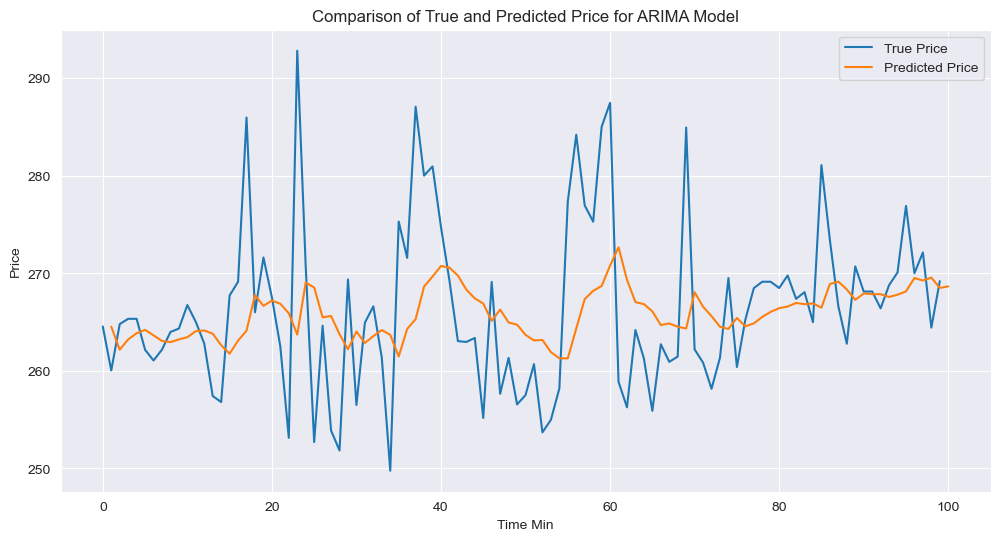

In [17]:
# 预测
predictions = model_fit.predict(start=1, end=len(lob_data)-1, typ='levels')

# 绘制预测值和真实值
plt.figure(figsize=(12, 6))
plt.plot(lob_data['price'][:100], label='True Price')
plt.plot(predictions[:100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for ARIMA Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()

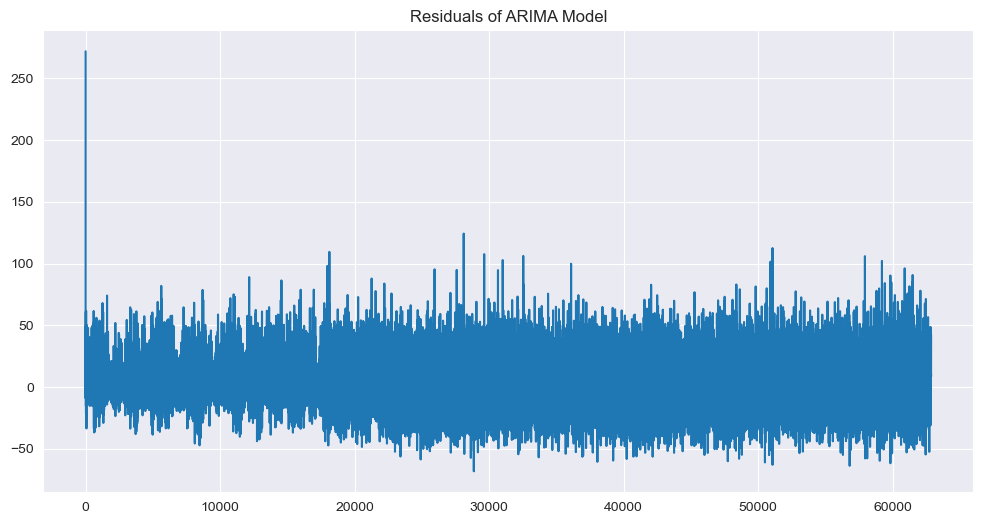

In [73]:
# 绘制拟合后的残差
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals of ARIMA Model')
plt.show()


## 2. XGBoost模型预测
使用arima模型预测price发现效果并不是很好，因为arima基于线性模型，而price的变化是非线性的，因此我们需要使用更加复杂的模型来预测price。

Sklearn提供了TimeseriesSplit函数，可以用于时间序列数据的交叉验证。我们可以使用这个函数来划分训练集和测试集，然后使用XGBoost模型进行预测。

In [7]:
# 添加时间特征
lob_data['Hour'] = lob_data['Datetime'].dt.hour
lob_data['Day'] = lob_data['Datetime'].dt.day
lob_data['Weekday'] = lob_data['Datetime'].dt.weekday
lob_data['Month'] = lob_data['Datetime'].dt.month

In [8]:
# 计算简单移动平均线（SMA）和相对强弱指数（RSI）
# 使用20分钟作为时间窗口

# 计算简单移动平均线（SMA）- 20分钟窗口
lob_data['MA20'] = lob_data['Min Ask Price'].rolling(window=20).mean()

# 计算RSI
def calculate_rsi(data, window=20):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lob_data['RSI20'] = calculate_rsi(lob_data['Min Ask Price'], window=20)

# 计算动量指标
# 计算20日动量
lob_data['Momentum20'] = lob_data['Min Ask Price'] - lob_data['Min Ask Price'].shift(20)

# 计算

# 显示添加了新特征后的前几行数据
lob_data[['Datetime', 'Min Ask Price', 'MA20', 'RSI20','Momentum20']].head(30)  # 显示前30行以查看一些填充的MA和RSI值

,Datetime,Min Ask Price,MA20,RSI20,Momentum20
0,2025-01-02 00:00:00,271.841538,NaN,NaN,NaN
1,2025-01-02 00:01:00,262.803138,NaN,NaN,NaN
2,2025-01-02 00:02:00,267.596615,NaN,NaN,NaN
3,2025-01-02 00:03:00,267.066274,NaN,NaN,NaN
4,2025-01-02 00:04:00,268.358289,NaN,NaN,NaN
5,2025-01-02 00:05:00,265.378682,NaN,NaN,NaN
6,2025-01-02 00:06:00,266.854972,NaN,NaN,NaN
7,2025-01-02 00:07:00,265.266362,NaN,NaN,NaN
8,2025-01-02 00:08:00,267.154976,NaN,NaN,NaN
9,2025-01-02 00:09:00,267.283837,NaN,NaN,NaN


In [9]:
# 使用XGBoost模型进行预测
# 选取特征和目标变量
X = lob_data[['Total Bid Quantity', 'Total Ask Quantity','Max Bid Price','RSI20','MA20' ,'Momentum20']]
y = lob_data['Min Ask Price']

# # 删除包含缺失值的行
X = X.dropna()
y = y[X.index]

# 划分训练集和测试集
train_size = int(0.9 * len(lob_data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# # 标准化特征,只对非时间特征进行标准化
scaler = StandardScaler()
X_train.iloc[:, :6] = scaler.fit_transform(X_train.iloc[:, :6])
X_test.iloc[:, :6] = scaler.transform(X_test.iloc[:, :6])

In [10]:
# 使用TimeSeriesSplit进行交叉验证，并使用grid search寻找最佳参数
tscv = TimeSeriesSplit(n_splits=5)

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# 使用GridSearchCV进行交叉验证
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X, y)

# 输出最佳参数
grid_search.best_params_ # {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

KeyboardInterrupt: 

In [20]:
# 使用最佳参数训练模型
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42,n_jobs=-1)
xgb_model.fit(X_train, y_train)

# 预测测试集
y_pred = xgb_model.predict(X_test)

# 计算测试集的MSE
mse = np.mean((y_pred - y_test) ** 2)
# 计算R^2
r2 = xgb_model.score(X_test, y_test)
mse, r2

(163.50524021037785, 0.5452232968039967)

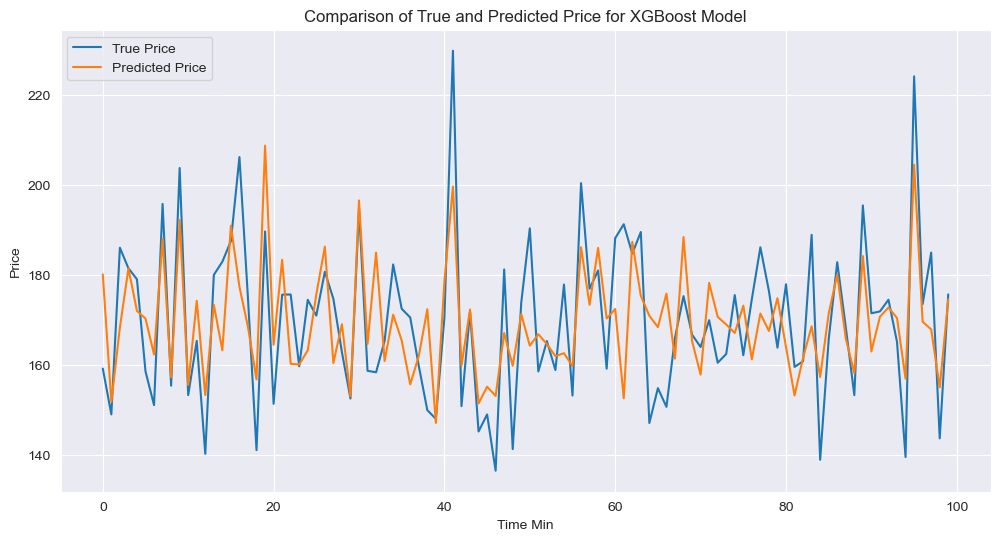

In [21]:
y_test_value=y_test.values
# 对比预测值和真实值,
plt.figure(figsize=(12, 6))
plt.plot(y_test_value[0:100], label='True Price')
plt.plot(y_pred[0:100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for XGBoost Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
# 随机森林模型预测
from sklearn.ensemble import RandomForestRegressor

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)

# 预测测试集
y_pred = rf_model.predict(X_test)

# 计算测试集的MSE
mse = np.mean((y_pred - y_test) ** 2)
# 计算R^2
r2 = rf_model.score(X_test, y_test)
mse, r2


(169.25440531745383, 0.529232455469729)

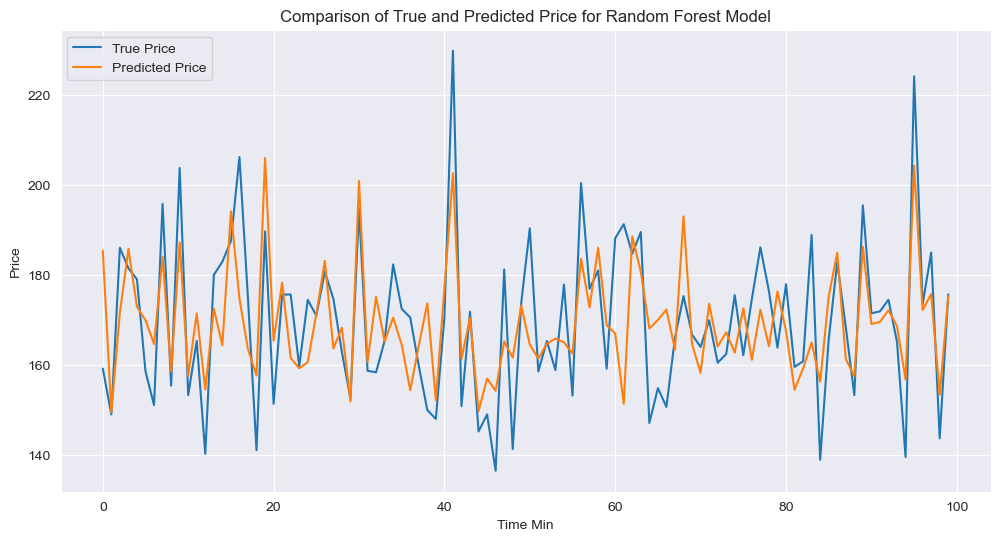

In [24]:
y_test_value=y_test.values
# 对比预测值和真实值,
plt.figure(figsize=(12, 6))
plt.plot(y_test_value[0:100], label='True Price')
plt.plot(y_pred[0:100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for Random Forest Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()
